# Best Subest Selection

- TA: HUANG Xinrui, HKUST

- Date: October 31, 2023

In [1]:
set.seed(20231031)
library(ggplot2)
library(reshape2)

## Real Data

- Here we apply the best subset selection approach to the `Hitters` dataset.
- We wish to predict a baseball player’s `Salary` on the basis of various statistics associated with performance in the previous year.

In [2]:
library(ISLR2)
head(Hitters)
dim(Hitters)
sum(is.na(Hitters$Salary))

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<fct>
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NA,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


[1] 322  20

[1] 59

In [3]:
# Exclude NA
Hitters <- na.omit(Hitters)
dim(Hitters)
sum(is.na(Hitters))

[1] 263  20

[1] 0

- The `regsubsets()` function (part of the R package `leaps`) performs best subset selection by identifying the best model that contains a given number of predictors.
- "**Best**" is quantified using RSS.
- `summary()` command outputs the best set of variables for each model size.

In [4]:
library(leaps)
regfit <- regsubsets(Salary ~ ., Hitters)
summary(regfit)

Subset selection object
Call: regsubsets.formula(Salary ~ ., Hitters)
19 Variables  (and intercept)
           Forced in Forced out
AtBat          FALSE      FALSE
Hits           FALSE      FALSE
HmRun          FALSE      FALSE
Runs           FALSE      FALSE
RBI            FALSE      FALSE
Walks          FALSE      FALSE
Years          FALSE      FALSE
CAtBat         FALSE      FALSE
CHits          FALSE      FALSE
CHmRun         FALSE      FALSE
CRuns          FALSE      FALSE
CRBI           FALSE      FALSE
CWalks         FALSE      FALSE
LeagueN        FALSE      FALSE
DivisionW      FALSE      FALSE
PutOuts        FALSE      FALSE
Assists        FALSE      FALSE
Errors         FALSE      FALSE
NewLeagueN     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun CRuns CRBI
1  ( 1 ) " "   " "  " "   " "  " " " "   " "   " "    " "   " "    " "   "*" 
2  ( 1 ) " "   "*"  " "   " "  " " " "   

- By default, `regsubsets()` only reports results up to the best eight-variable model.
- the `nvmax` option can be used in order to return as many variables as are desired.

In [5]:
regfit_full <- regsubsets(Salary ~ ., data = Hitters, nvmax = 19)
summary(regfit_full)
class(regfit_full)

Subset selection object
Call: regsubsets.formula(Salary ~ ., data = Hitters, nvmax = 19)
19 Variables  (and intercept)
           Forced in Forced out
AtBat          FALSE      FALSE
Hits           FALSE      FALSE
HmRun          FALSE      FALSE
Runs           FALSE      FALSE
RBI            FALSE      FALSE
Walks          FALSE      FALSE
Years          FALSE      FALSE
CAtBat         FALSE      FALSE
CHits          FALSE      FALSE
CHmRun         FALSE      FALSE
CRuns          FALSE      FALSE
CRBI           FALSE      FALSE
CWalks         FALSE      FALSE
LeagueN        FALSE      FALSE
DivisionW      FALSE      FALSE
PutOuts        FALSE      FALSE
Assists        FALSE      FALSE
Errors         FALSE      FALSE
NewLeagueN     FALSE      FALSE
1 subsets of each size up to 19
Selection Algorithm: exhaustive
          AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun CRuns CRBI
1  ( 1 )  " "   " "  " "   " "  " " " "   " "   " "    " "   " "    " "   "*" 
2  ( 1 )  " "   "*"

[1] "regsubsets"

- We have totally 19 models, each of them corresponds to a single setting of the hyperparameter, i.e., the number of variables to include.
- How do we choose the hyper-parameter?

### Cross-validation for best subset selection

In [6]:
predict.regsubsets <- function(object, newdata, id,...){
  form  <- as.formula(object$call[[2]])
  mat   <- model.matrix(form, newdata)
  coefi <- coef(object, id=id)
  mat[, names(coefi)]%*%coefi
}

In [7]:
nfolds <- 10
n <- nrow(Hitters)

dat_idx <- sample(1:nrow(Hitters), nrow(Hitters), replace = FALSE)
cv_err <- matrix(0, nfolds, 19)
for (i in 1:nfolds) {
    idx_test <- dat_idx[((i - 1) * n / nfolds + 1):(i * n / nfolds)]

    regfit_cv <- regsubsets(Salary ~ ., data = Hitters[-idx_test, ], nvmax = 19)
    for (j in 1:19) {
        pred <- predict(regfit_cv, Hitters[idx_test, ], id = j)
        cv_err[i, j] <- mean((Hitters$Salary[idx_test] - c(pred))^2) # error in the obsv
    }
}

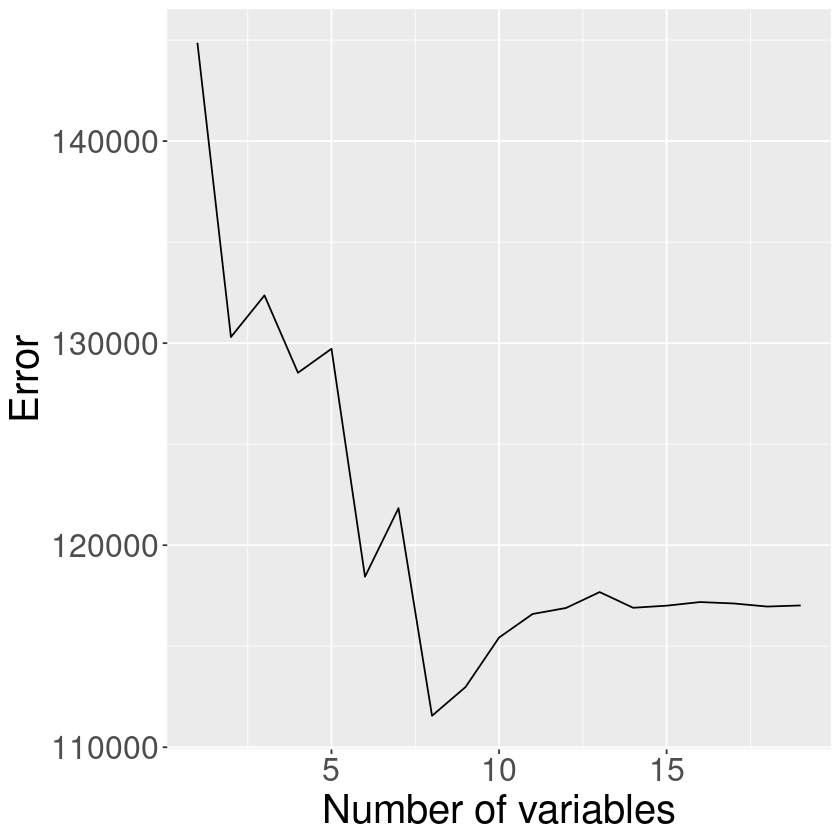

In [8]:
ggplot(data = NULL, aes(x = 1:19, y = colMeans(cv_err))) +
    geom_line() +
    xlab("Number of variables") +
    ylab("Error") +
    theme(text = element_text(size = 24))

### Other metrics to evaluate model performance

In [9]:
reg_summary <- summary(regfit_full)
names(reg_summary)
reg_summary$rss

[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"

[1] 36179679 30646560 29249297 27970852 27149899 26194904 25906548 25136930
 [9] 24814051 24500402 24387345 24333232 24289148 24248660 24235177 24219377
[17] 24209447 24201837 24200700

- The `summary()` function also returns R2, RSS, adjusted R2, Cp, and BIC. We can examine these to try to select the best overall model.
Recall: 
$$C_p=\frac{1}{n}(RSS+2d\hat{\sigma}^2)$$
$$AIC=\frac{1}{n}(RSS+2d\hat{\sigma}^2)$$
$$BIC=\frac{1}{n}(RSS+\log(n)d\hat{\sigma}^2)$$
$$adjR^2=1-\frac{RSS/(n-d-1)}{TSS/(n-1)}$$

[1] 11

[1] 10

[1] 6

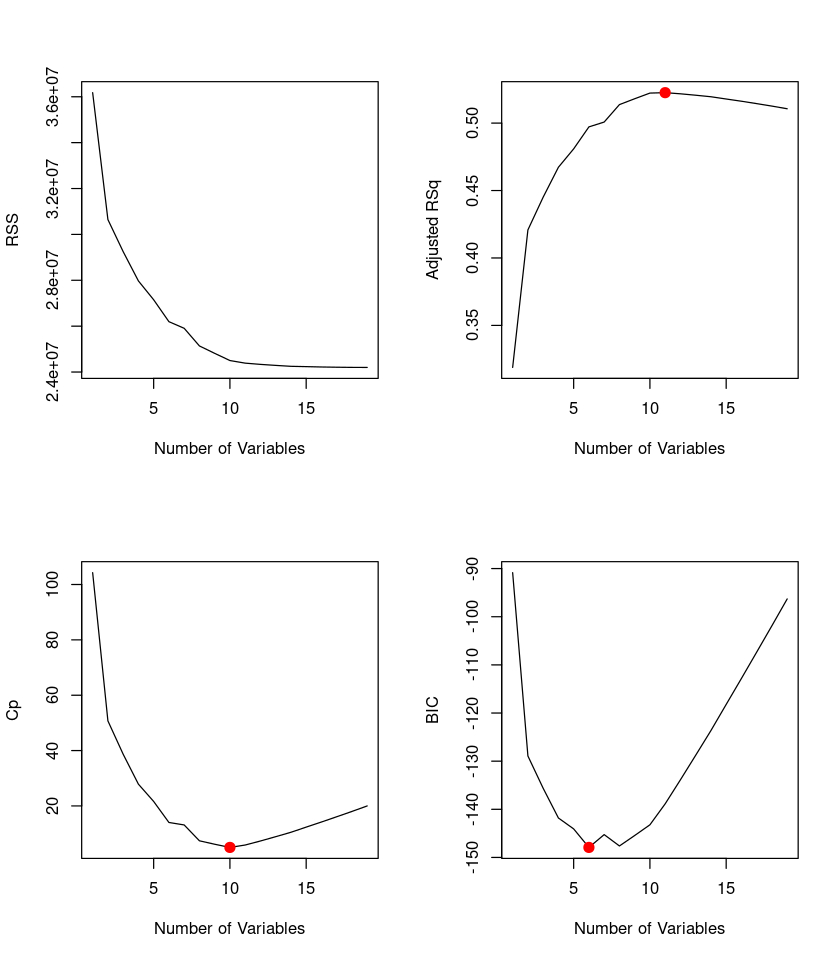

In [10]:
library(repr)
options(repr.plot.height = 8)
par(mfrow = c(2, 2))
plot(reg_summary$rss, xlab = "Number of Variables", ylab = "RSS", type = "l")
plot(reg_summary$adjr2, xlab = "Number of Variables", ylab = "Adjusted RSq", type = "l")

which.max(reg_summary$adjr2)
points(11, reg_summary$adjr2[11], col = "red", cex = 2, pch = 20)
plot(reg_summary$cp, xlab = "Number of Variables", ylab = "Cp", type = "l")
which.min(reg_summary$cp)
points(10, reg_summary$cp[10], col = "red", cex = 2, pch = 20)
which.min(reg_summary$bic)
plot(reg_summary$bic, xlab = "Number of Variables", ylab = "BIC", type = "l")
points(6, reg_summary$bic[6], col = "red", cex = 2, pch = 20)

### Calculating AIC “by hand”

In [11]:
#attach(reg_summary)
#d <- c(1:19) + 1 + 1 # Coefficients + intercept + error
# sig_sq <- rss / (n - c(1:19) - 1) # Wrong, don't adjust the variance twice
##sig_sq <- rss / n
#aic <- (rss + 2 * d * sig_sq) / n
#detach(reg_summary)

#aic

# attach(reg_summary)
# d <- c(1:19) + 1 + 1 # Coefficients + intercept + error
# aic <- n * (log(2*pi) + 1 + log(rss/n)) + d * 2
# detach(reg_summary)

# aic

In [12]:
#which.min(aic)
#plot(aic, xlab = "Number of Variables", ylab = "AIC", type = "l")
#points(which.min(aic), min(aic), col = "red", cex = 2, pch = 20)

In [13]:
attach(reg_summary)
d <- c(1:19) # number of predictors
sig_sq <- rss[19] / (n - 19) # estimation of residual variance of the FULL model
aic <- (rss + 2 * d * sig_sq) / n
detach(reg_summary)

aic

[1] 138319.6 118035.3 113476.8 109370.0 107002.8 104125.9 103783.7 101611.6
 [9] 101138.2 100699.9 101024.2 101572.7 102159.4 102759.7 103462.6 104156.8
[17] 104873.3 105598.6 106348.5

[1] 10

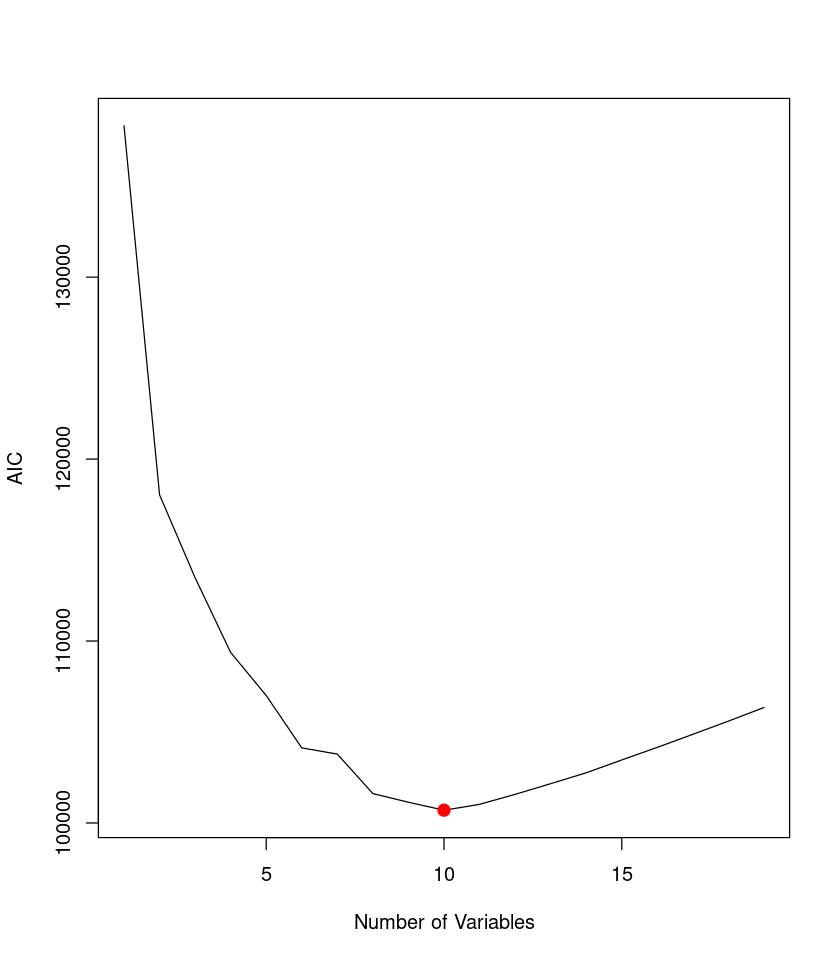

In [14]:
which.min(aic)
plot(aic, xlab = "Number of Variables", ylab = "AIC", type = "l")
points(which.min(aic), min(aic), col = "red", cex = 2, pch = 20)

## Simulation study

### A simple linear model

Suppose we have the data matrix $X \in \mathbb{R}^{N \times P}$ of $N$ samples and $P$ predictor variables and the response vector $y \in \mathbb{R}^{N \times 1}$.
Here only a few of the predictor variables have effects on $y$ while the remaining are redundant.
$X$ and $y$ follow the linear relationship
$$y = X \beta + \epsilon,$$
where $\epsilon$ are noise terms.

### Simple training and test scheme

- From $1$ to $\text{nrep}$,

    - Generate predictor variables $X$ and true response variable $y_0$.

    - Split the whole dataset into training and test sets.

    - For different $\text{SNR}$,
    
        - Generate noisy observations $y$.

        - Then we perform the best subset selection with the predictor size from $1$ to $P$ and evaluate the prediction accuracy using the test set.
    
    - End.
  
- End.

In [15]:
N <- 300
ntrain <- 100 # 100 for training
ntest <- 200 # 200 for test
P <- 25
p_true <- 5
SNR_vec <- c(0.1, 0.3, 0.5, 0.7) # We will evaluate the performances under different SNR settings
nrep <- 50 # Repeat 50 times for each setting

beta <- rep(0, P)
beta[1:p_true] <- 1 # The first p_true predictors have non-zero effects

X <- matrix(runif(N * P), N, P)
colnames(X) <- paste0("X", 1:P)
y0 <- X %*% as.matrix(beta)

X <- data.frame(X)
colnames(X) <- paste0("X", 1:P)

In [16]:
err <- data.frame()
for (i in 1:nrep) {
    train_idx <- sample(1:N, ntrain, replace = FALSE)
    
    for (j in 1:length(SNR_vec)) {
        SNR <- SNR_vec[j]
        y <- y0 + rnorm(N, sd = sqrt(var(y0) / SNR))  # Noisy observation
        data_train <- data.frame(y = y[train_idx], X[train_idx, ])
        data_test <- data.frame(y = y[-train_idx], X[-train_idx, ])

        regfit_full <- regsubsets(y ~ ., data_train, nvmax = P)
        for (p in 1:P) {
            pred <- predict(regfit_full, data_test, id = p)
            err <- rbind(
                err,
                data.frame(
                    Trial = i,
                    Size = p,
                    SNR = SNR,
                    Error = mean((y[-train_idx] - c(pred))^2)
                )
            )
        }
    }
}

err$Size <- factor(err$Size, levels = 1:P)
err$SNR <- paste0("SNR = ", err$SNR)
head(err)

,Trial,Size,SNR,Error
,<int>,<fct>,<chr>,<dbl>
1,1,1,SNR = 0.1,5.221174
2,1,2,SNR = 0.1,5.461282
3,1,3,SNR = 0.1,5.456548
4,1,4,SNR = 0.1,5.773518
5,1,5,SNR = 0.1,6.920331
6,1,6,SNR = 0.1,7.071516


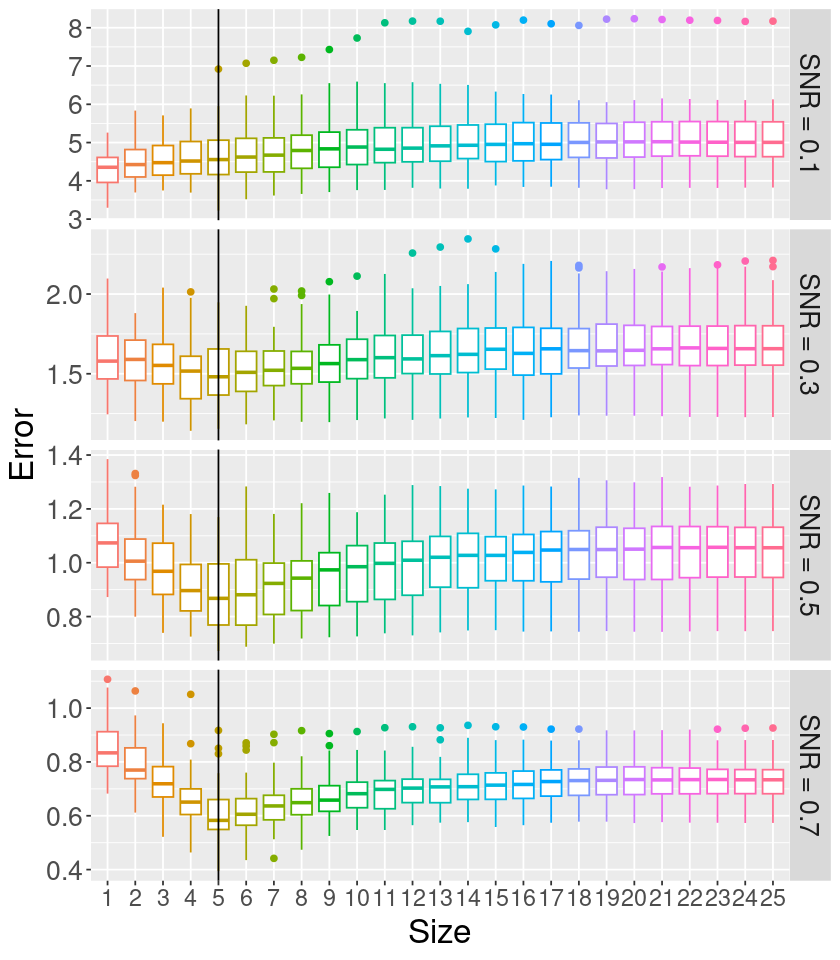

In [17]:
ggplot(data = err, aes(x = Size, y = Error, color = Size)) +
    geom_boxplot() +
    geom_vline(xintercept = p_true, color = "black") + # True predictors
    theme(
        text = element_text(size = 20),
        axis.text.x = element_text(size = 14),
        legend.position = "none"
    ) +
    facet_grid(SNR ~ ., scales = "free_y")

### Cross validation

- Generate predictor variables $X$ and true response variable $y_0$.

- Divide the whole dataset into $K$ folds.

- For different $\text{SNR}$,
  
    - Generate noisy observations $y$.

    - Each time use $K-1$ folds as the training set and perform the best subset selection with the predictor size from $1$ to $P$. Then evaluate the model performance using the remaining one as the test set.
  
- End.

In [18]:
set.seed(1101)
N <- 100
P <- 25
p_true <- 5
SNR_vec <- c(0.2, 0.4, 0.6, 0.8) # We will evaluate the performances under different SNR settings

beta <- rep(0, P)
beta[1:p_true] <- 1 # The first p_true predictors have non-zero effects

X <- matrix(runif(N * P), N, P)
colnames(X) <- paste0("X", 1:P)
y0 <- X %*% as.matrix(beta)

X <- data.frame(X)
colnames(X) <- paste0("X", 1:P)

In [19]:
set.seed(1101)
nfolds <- 10
# dat_idx <- sample(1:N, N, replace = FALSE)
dat_idx <- 1:N
err_cv <- array(0, dim = c(P, length(SNR_vec), nfolds))
for (i in 1:length(SNR_vec)) {
    SNR <- SNR_vec[i]
    y <- y0 + rnorm(N, sd = sqrt(var(y0) / SNR)) # Noisy observation
    dat <- data.frame(y = y, X) # Whole dataset
    
    for (k in 1:nfolds) {
        idx_test <- dat_idx[((k - 1) * N / nfolds + 1):(k * N / nfolds)]

        regfit_cv <- regsubsets(y ~ ., data = dat[-idx_test, ], nvmax = P)
        for (p in 1:P) {
            pred <- predict(regfit_cv, dat[idx_test, ], id = p)
            err_cv[p, i, k] <- mean((y[idx_test] - c(pred))^2)
        }
    }
}

In [20]:
err_cv <- data.frame(1:P, apply(err_cv, MARGIN = c(1, 2), FUN = mean))
colnames(err_cv) <- c("Size", paste0("SNR = ", SNR_vec))
head(err_cv)

,Size,SNR = 0.2,SNR = 0.4,SNR = 0.6,SNR = 0.8
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2.179569,1.0325197,0.8935000,0.6174020
2,2,2.374981,0.9955343,0.6984209,0.6493467
3,3,2.378059,1.0042957,0.6892142,0.5482550
4,4,2.377440,0.9908203,0.6251818,0.4197608
5,5,2.275746,0.9593625,0.6478613,0.4146739
6,6,2.405164,0.8290511,0.6391411,0.4227489


In [21]:
err_cv <- melt(
    data = err_cv,
    id.vars = "Size",
    variable.name = "SNR",
    value.name = "Test error"
)
head(err_cv)

,Size,SNR,Test error
,<int>,<fct>,<dbl>
1,1,SNR = 0.2,2.179569
2,2,SNR = 0.2,2.374981
3,3,SNR = 0.2,2.378059
4,4,SNR = 0.2,2.377440
5,5,SNR = 0.2,2.275746
6,6,SNR = 0.2,2.405164


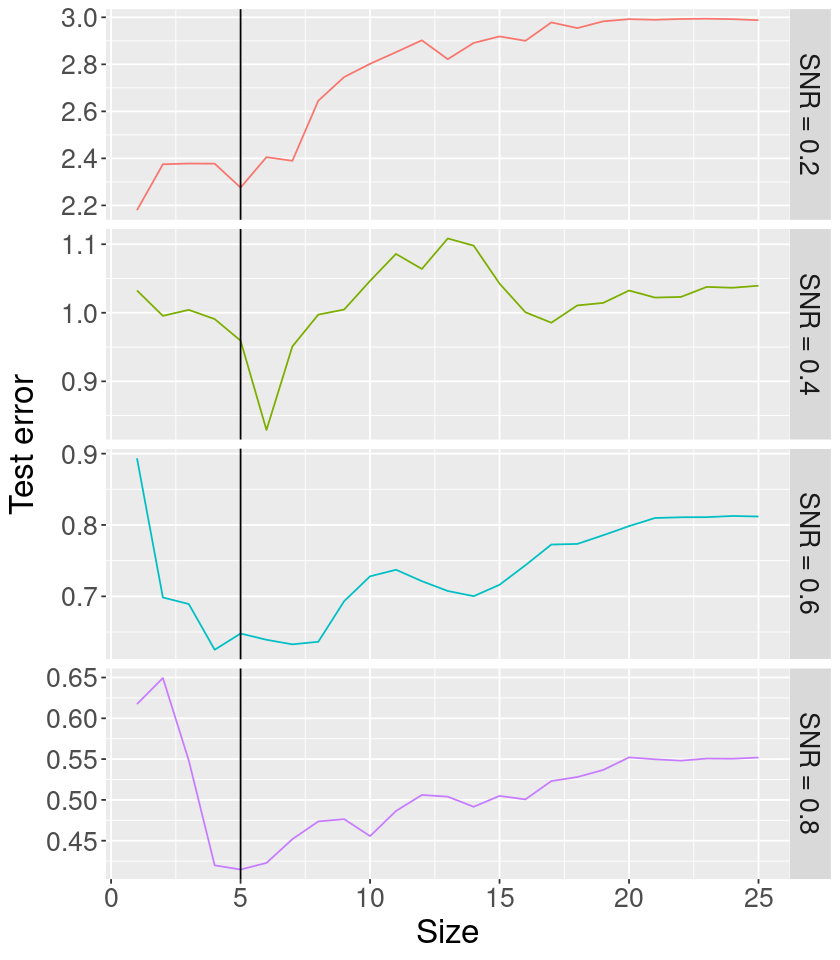

In [22]:
ggplot(data = err_cv, aes(x = Size, y = `Test error`, color = SNR)) +
    geom_line() +
    geom_vline(xintercept = p_true, color = "black") + # True predictors
    theme(
        text = element_text(size = 20),
        legend.position = "none"
    ) +
    facet_grid(SNR ~ ., scales = "free_y")

### A wrong cross validation scheme

- Generate predictor variables $X$ and true response variable $y_0$.

- Divide the whole dataset into $K$ folds.

- For different $\text{SNR}$,
  
    - Generate noisy observations $y$.
    
    - Perform best subset selection using the whole dataset.
    
    - For $k = 1,\dots,K$,

        - Use the $k$-th fold as the test set to evaluate the prediction accuracy.
        
    - End.
  
- End.

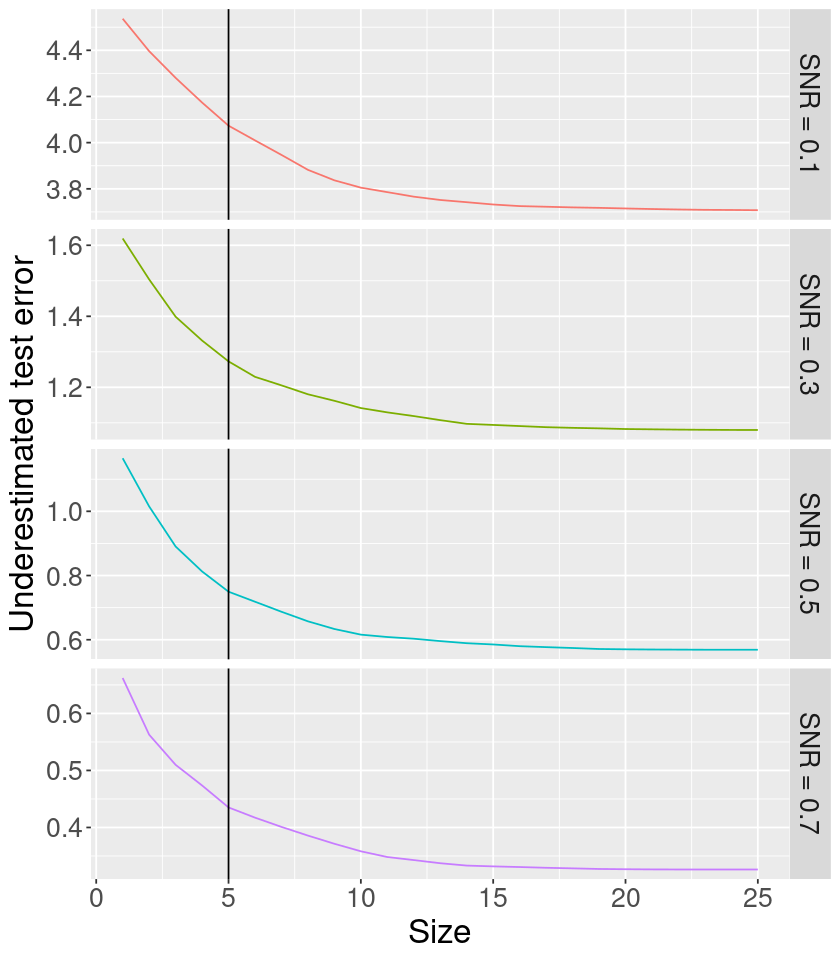

In [23]:
N <- 100
P <- 25
p_true <- 5
SNR_vec <- c(0.1, 0.3, 0.5, 0.7) # We will evaluate the performances under different SNR settings

beta <- rep(0, P)
beta[1:p_true] <- 1 # The first p_true predictors have non-zero effects

X <- matrix(runif(N * P), N, P)
colnames(X) <- paste0("X", 1:P)
y0 <- X %*% as.matrix(beta)

X <- data.frame(X)
colnames(X) <- paste0("X", 1:P)

nfolds <- 10
dat_idx <- sample(1:N, N, replace = FALSE)
err_cv <- array(0, dim = c(P, length(SNR_vec), nfolds))
for (i in 1:length(SNR_vec)) {
    SNR <- SNR_vec[i]
    y <- y0 + rnorm(N, sd = sqrt(var(y0) / SNR))
    dat <- data.frame(y = y, X) # Whole dataset
    regfit_cv <- regsubsets(y ~ ., data = dat, nvmax = P) # Perform best subset selection using the whole dataset
    
    for (k in 1:nfolds) {
        idx_test <- dat_idx[((k - 1) * N / nfolds + 1):(k * N / nfolds)]

        for (p in 1:P) {
            pred <- predict(regfit_cv, dat[idx_test, ], id = p)
            err_cv[p, i, k] <- mean((y[idx_test] - c(pred))^2)
        }
    }
}

err_cv <- data.frame(1:P, apply(err_cv, MARGIN = c(1, 2), FUN = mean))
colnames(err_cv) <- c("Size", paste0("SNR = ", SNR_vec))

err_cv <- melt(
    data = err_cv,
    id.vars = "Size",
    variable.name = "SNR",
    value.name = "Underestimated test error"
)

ggplot(data = err_cv, aes(x = Size, y = `Underestimated test error`, color = SNR)) +
    geom_line() +
    geom_vline(xintercept = p_true, color = "black") + # True predictors
    theme(
        text = element_text(size = 20),
        legend.position = "none"
    ) +
    facet_grid(SNR ~ ., scales = "free_y")